# Edekebon Elaijah
# Makerere University 
# 2023/HD05/04665U 
#  2300704665


# Importing all the neccessary libraries

In [34]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score
import shutil
from imblearn.over_sampling import SMOTE
import pandas as pd
import IPython.display as ipd
from tqdm import tqdm
import subprocess
import xml.etree.ElementTree as ET

plt.style.use('ggplot')


# Loading the video dataset and checking some key important feature about the dataset

In [3]:
# Loading the video capture
cap = cv2.VideoCapture('C:/Users/DELL/Desktop/SEM 2/computer vision/Exam/final/nakawa_output.avi')

In [4]:
# Finiding the total number of frames in video dataset
total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
print("Total number of frames:", total_frames)

Total number of frames: 85320.0


In [5]:
# Getting the Video height and width
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
print(f'Height {height}, Width {width}')

Height 240.0, Width 320.0


In [6]:
# knowing frames per second of the video
fps = cap.get(cv2.CAP_PROP_FPS)
print(f'FPS : {fps:0.2f}')

FPS : 30.00


In [7]:
cap.release()

In [8]:
cap = cv2.VideoCapture('C:/Users/DELL/Desktop/SEM 2/computer vision/Exam/final/nakawa_output.avi')
ret, img = cap.read()

if ret:  
    print(f'Returned {ret} and img of shape {img.shape}')
else:
    print("Failed to read frame from video.")


Returned True and img of shape (240, 320, 3)


In [9]:
def display_cv2_img(img, figsize=(10, 10)):
    img_ = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(img_)
    ax.axis("off")

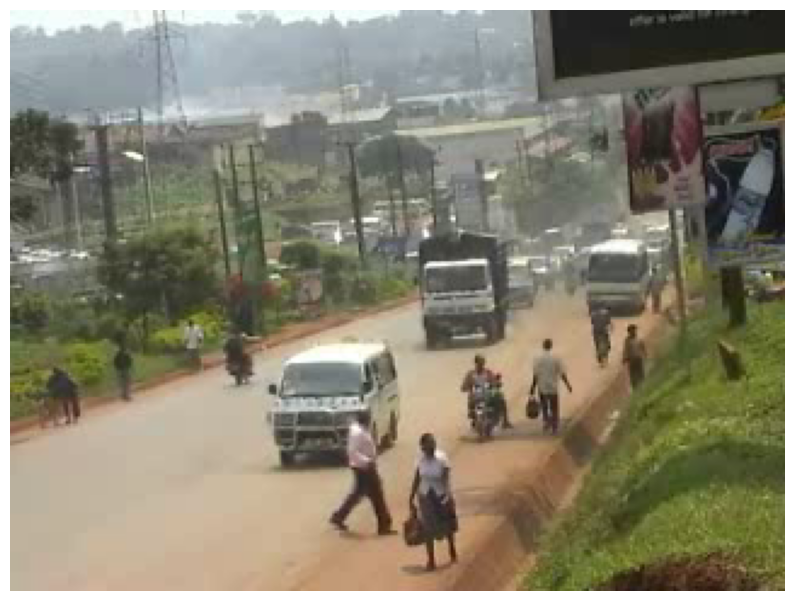

In [10]:
display_cv2_img(img)

In [11]:
cap.release()

In [12]:
# Creating of a directory to save my frames
save_dir = "frames"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

cap = cv2.VideoCapture('C:/Users/DELL/Desktop/SEM 2/computer vision/Exam/final/nakawa_output.avi')
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

img_idx = 0
for frame in range(n_frames):
    ret, img = cap.read()
    if ret == False:
        break
    if frame % 100 == 0:
        # Save the frame
        cv2.imwrite(os.path.join(save_dir, f"frame_{frame}.jpg"), img)
        img_idx += 1

cap.release()
print("Frames saved successfully.")


Frames saved successfully.


In [13]:

frames_dir = 'frames'

# saving the extracted frames
output_dir = 'extracted_frames'
os.makedirs(output_dir, exist_ok=True)

# extracting image information from XML annotation
def extract_image_info(image):
    image_path = os.path.join(frames_dir, image.attrib['name'])
    width = int(image.attrib['width'])
    height = int(image.attrib['height'])
    boxes = []
    for box in image.findall('box'):
        label = box.attrib['label']
        occluded = int(box.attrib['occluded'])
        xtl = float(box.attrib['xtl'])
        ytl = float(box.attrib['ytl'])
        xbr = float(box.attrib['xbr'])
        ybr = float(box.attrib['ybr'])
        boxes.append({'label': label, 'occluded': occluded, 'xtl': xtl, 'ytl': ytl, 'xbr': xbr, 'ybr': ybr})
    return {'image_path': image_path, 'width': width, 'height': height, 'boxes': boxes}

# Parsing XML file
tree = ET.parse('annotations.xml')
root = tree.getroot()

# Extract all information for each image
images_data = []
for image in root.findall('.//image'):
    images_data.append(extract_image_info(image))

# Extracting and save ROIs
for image_info in images_data:
    image_path = image_info['image_path']
    image = cv2.imread(image_path)
    
    if image is None:
        print(f"Image {image_path} not found.")
        continue
    
    for idx, box in enumerate(image_info['boxes']):
        xtl, ytl, xbr, ybr = int(box['xtl']), int(box['ytl']), int(box['xbr']), int(box['ybr'])
        label = box['label']
        
        # The extraction of the ROI
        roi = image[ytl:ybr, xtl:xbr]
        
        # Constructing the output filename
        filename = os.path.basename(image_path)
        filename_wo_ext = os.path.splitext(filename)[0]
        output_filename = f"{filename_wo_ext}_{label}_{idx}.png"
        output_filepath = os.path.join(output_dir, output_filename)
        
        # Save the ROI as a PNG file
        cv2.imwrite(output_filepath, roi)
    

In [15]:

# Directory containing the extracted frames
extracted_frames_dir = 'extracted_frames'


image_size = (64, 64) 
labels = []
features = []

# Loading the images and preparing data
for label_dir in os.listdir(extracted_frames_dir):
    label_path = os.path.join(extracted_frames_dir, label_dir)
    if os.path.isdir(label_path):
        for image_file in os.listdir(label_path):
            image_path = os.path.join(label_path, image_file)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is not None:
                image_resized = cv2.resize(image, image_size)
                features.append(image_resized.flatten())
                labels.append(label_dir)

features = np.array(features)
labels = np.array(labels)


In [22]:
# Path to the dataset
data = "./extracted_frames"

# Listing of all classes in the dataset directory
classes = os.listdir(data)
print("Classes: {}".format(classes))


test_split = 0.2


train_dir = 'training'
shutil.rmtree(train_dir, ignore_errors=True)
os.mkdir(train_dir)


test_dir = 'testing'
shutil.rmtree(test_dir, ignore_errors=True)
os.mkdir(test_dir)

# Split the data into training and validation sets
for class_name in classes:
    class_dir = os.path.join(data, class_name)
    train_class_dir = os.path.join(train_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)

    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)

   
    images = os.listdir(class_dir)
    num_images = len(images)
    num_test = int(test_split * num_images)

    # Moving images to the training directory
    for img in images[:-num_test]:
        src_path = os.path.join(class_dir, img)
        dst_path = os.path.join(train_class_dir, img)
        shutil.copy(src_path, dst_path)

    # Moving images to the test directory
    for img in images[-num_test:]:
        src_path = os.path.join(class_dir, img)
        dst_path = os.path.join(test_class_dir, img)
        shutil.copy(src_path, dst_path)


Classes: ['Bus', 'Motorcycle', 'Truck']


# Distribution of classes int the dataset

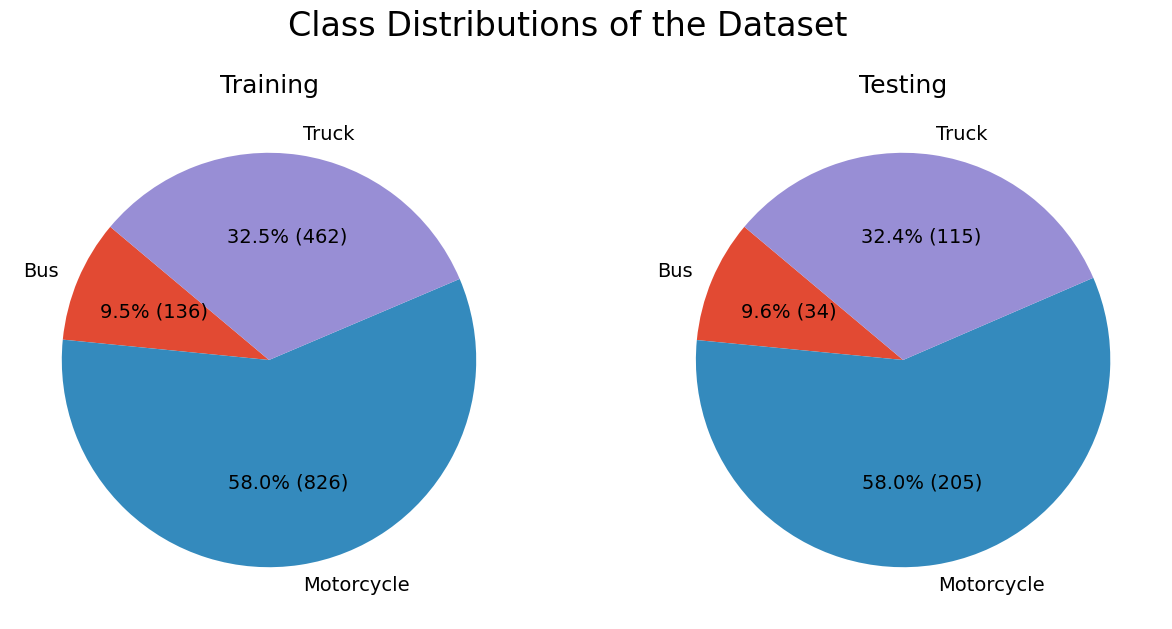

In [23]:

def get_class_distribution(directory):
    class_labels = []
    for root, dirs, files in os.walk(directory):
        if len(files) > 0:
            class_name = os.path.basename(root)
            class_labels.extend([class_name] * len(files))

    class_labels = np.array(class_labels)
    unique_labels, label_indices = np.unique(class_labels, return_inverse=True)
    class_counts = np.bincount(label_indices)
    return unique_labels, class_counts

def plot_class_distribution(data, title, ax):
    counts = data[1]
    class_names = data[0]

    def autopct(pct):
        total = sum(counts)
        count = int(pct * total / 100.0)
        return f'{pct:.1f}% ({count})'
    
    wedges, texts, autotexts = ax.pie(
        counts, labels=class_names, autopct=autopct, startangle=140, textprops={'fontsize': 14}
    )
    ax.set_title(title, fontsize=18)

train_labels = get_class_distribution(train_dir)
test_labels = get_class_distribution(test_dir)

fig, axes = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('Class Distributions of the Dataset', fontsize=24)
plt.subplots_adjust(top=0.85)

plot_class_distribution(train_labels, 'Training', axes[0])
plot_class_distribution(test_labels, 'Testing', axes[1])

plt.show()


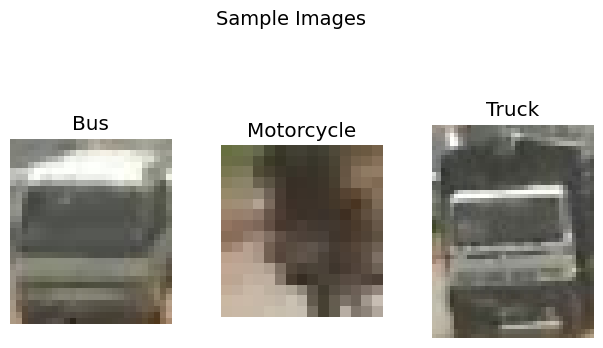

In [24]:
train_data = "training"
test_data = "testing"


# Geting sample images from each class
sample_images = [glob(os.path.join(train_data, class_name, "*"))[0] for class_name in classes]

def plot_images(images, names): 
    num_images = len(images)
    fig, axs = plt.subplots(1, num_images)    
    fig.tight_layout(pad=0.5)
    plt.suptitle('Sample Images', fontsize=14)
    
    for i, ax in enumerate(axs.flat):
        
        if isinstance(images[i], str): 
            image = plt.imread(images[i])
        else:  
            image = images[i]
        ax.imshow(image)
        ax.axis('off')

        
        ax.set_title(names[i])

    plt.show()
    
plot_images(sample_images, classes)


# Color histograms andFeature extraction algorithm

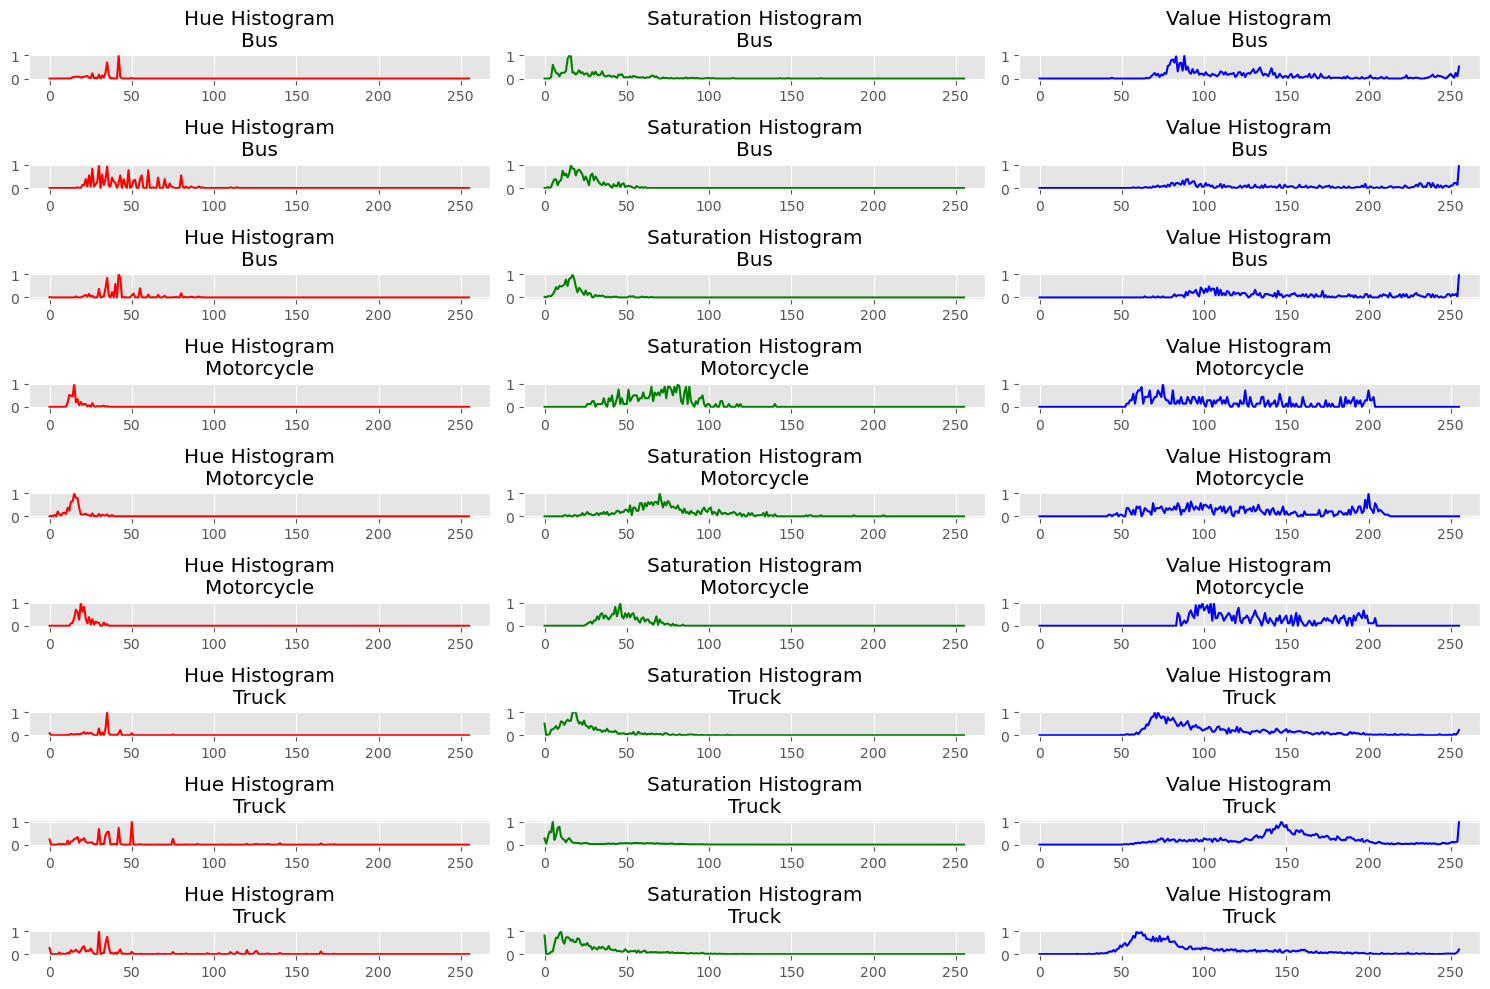

In [25]:

def extract_color_histogram(image):
    
    # Converting the image to the HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # these computes the histogram for each channel (Hue, Saturation, Value)
    hist_hue = cv2.calcHist([hsv_image], [0], None, [256], [0, 256])
    hist_saturation = cv2.calcHist([hsv_image], [1], None, [256], [0, 256])
    hist_value = cv2.calcHist([hsv_image], [2], None, [256], [0, 256])
    
    # Normalizing the histograms
    cv2.normalize(hist_hue, hist_hue, 0, 1, cv2.NORM_MINMAX)
    cv2.normalize(hist_saturation, hist_saturation, 0, 1, cv2.NORM_MINMAX)
    cv2.normalize(hist_value, hist_value, 0, 1, cv2.NORM_MINMAX)
    
    # Concatenate the histograms into single feature vector
    feature_vector = np.concatenate([hist_hue, hist_saturation, hist_value]).flatten()
    
    return feature_vector

def extract_features_from_folder(folder_path, feature_extractor):
    features = []
    labels = []
    
    class_folders = os.listdir(folder_path)
    for class_folder in class_folders:
        class_path = os.path.join(folder_path, class_folder)
        if os.path.isdir(class_path):
            class_label = class_folder
            
            image_files = os.listdir(class_path)
            
            for image_file in image_files:
                image_path = os.path.join(class_path, image_file)
                
                # Loading the image
                image = cv2.imread(image_path)
                
                # Extracting the color histogram features
                extracted_features = feature_extractor(image)
                
                features.append(extracted_features)
                labels.append(class_label) 
                
    return features, labels

def visualize_histograms(images, feature_extractor, class_labels):
    plt.figure(figsize=(15, 10))
    num_samples = len(images)
    
    for i, (image, label) in enumerate(zip(images, class_labels)):
        feature_vector = feature_extractor(image)
        hue_hist = feature_vector[:256]
        sat_hist = feature_vector[256:512]
        val_hist = feature_vector[512:]
        
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.plot(hue_hist, color='r')
        plt.title(f'Hue Histogram\n{label}')
        
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.plot(sat_hist, color='g')
        plt.title(f'Saturation Histogram\n{label}')
        
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.plot(val_hist, color='b')
        plt.title(f'Value Histogram\n{label}')
        
    plt.tight_layout()
    plt.show()


folder_path = './extracted_frames'  
features, labels = extract_features_from_folder(folder_path, extract_color_histogram)

# Select a few sample images for visualization
sample_images = []
sample_labels = []
class_folders = os.listdir(folder_path)
for class_folder in class_folders:
    class_path = os.path.join(folder_path, class_folder)
    if os.path.isdir(class_path):
        image_files = os.listdir(class_path)
        for image_file in image_files[:3]:  
            image_path = os.path.join(class_path, image_file)
            image = cv2.imread(image_path)
            sample_images.append(image)
            sample_labels.append(class_folder)


visualize_histograms(sample_images, extract_color_histogram, sample_labels)


In [26]:
train_features, train_labels = extract_features_from_folder(train_dir, extract_color_histogram)
test_features, test_labels = extract_features_from_folder(test_dir, extract_color_histogram)

# inspecting the extracted features and labels
print("Training features shape:", np.array(train_features).shape)
print("Training labels shape:", np.array(train_labels).shape)
print("Test features shape:", np.array(test_features).shape)
print("Test labels shape:", np.array(test_labels).shape)


Training features shape: (1425, 768)
Training labels shape: (1425,)
Test features shape: (355, 768)
Test labels shape: (355,)


# Model training and evaluation

Support Vector Machine Accuracy: 0.8310
Support Vector Machine Precision: 0.8453
Support Vector Machine Recall: 0.8310
Support Vector Machine F1 Score: 0.8339
Support Vector Machine AUC: 0.8177381041061422
Confusion Matrix:
 [[ 16   0  18]
 [  5 179  22]
 [ 10   5 100]]
              precision    recall  f1-score   support

         Bus       0.52      0.47      0.49        34
  Motorcycle       0.97      0.87      0.92       206
       Truck       0.71      0.87      0.78       115

    accuracy                           0.83       355
   macro avg       0.73      0.74      0.73       355
weighted avg       0.85      0.83      0.83       355





C:\Users\DELL\AppData\Local\Temp\ipykernel_2296\3650900931.py:65: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, model_results], ignore_index=True)


Random Forest Accuracy: 0.9127
Random Forest Precision: 0.9153
Random Forest Recall: 0.9127
Random Forest F1 Score: 0.9084
Random Forest AUC: 0.9366164469164618
Confusion Matrix:
 [[ 16   0  18]
 [  0 198   8]
 [  5   0 110]]
              precision    recall  f1-score   support

         Bus       0.76      0.47      0.58        34
  Motorcycle       1.00      0.96      0.98       206
       Truck       0.81      0.96      0.88       115

    accuracy                           0.91       355
   macro avg       0.86      0.80      0.81       355
weighted avg       0.92      0.91      0.91       355



k-Nearest Neighbors Accuracy: 0.7127
k-Nearest Neighbors Precision: 0.7995
k-Nearest Neighbors Recall: 0.7127
k-Nearest Neighbors F1 Score: 0.7390
k-Nearest Neighbors AUC: 0.815704587026875
Confusion Matrix:
 [[ 21   0  13]
 [ 13 152  41]
 [ 34   1  80]]
              precision    recall  f1-score   support

         Bus       0.31      0.62      0.41        34
  Motorcycle       0.99    

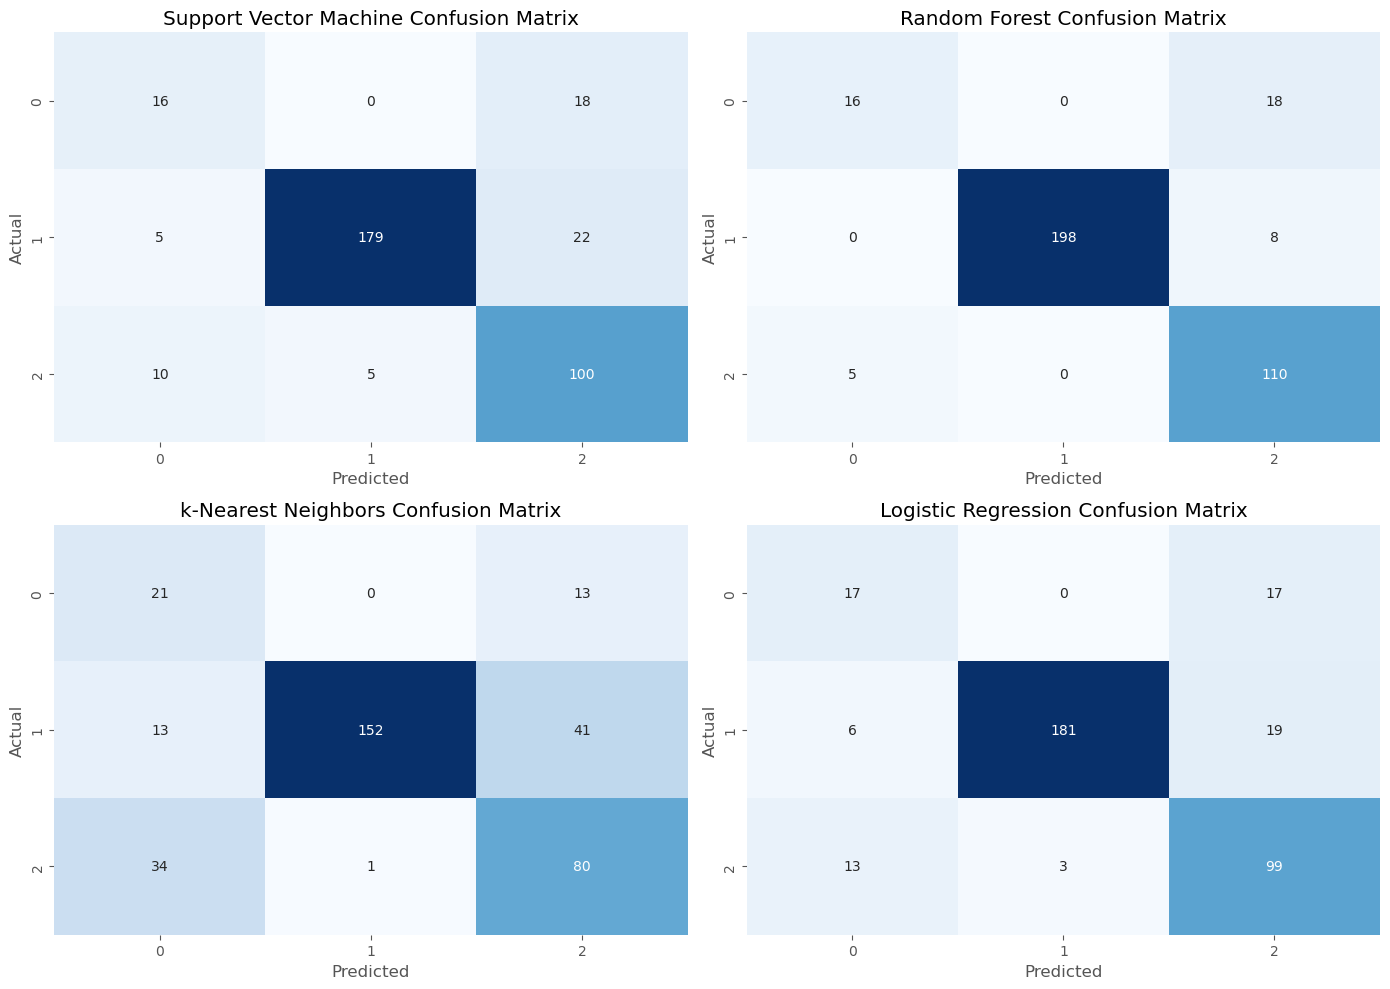

In [27]:
results_df = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score", "AUC"])

# Encoding labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Standardizing features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
train_features_smote, train_labels_smote = smote.fit_resample(train_features_scaled, train_labels_encoded)


models = {
    "Support Vector Machine": SVC(kernel='linear', probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "k-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Logistic Regression": LogisticRegression(random_state=42)
}

for model_name, model in models.items():
    model.fit(train_features_smote, train_labels_smote)
    predictions = model.predict(test_features_scaled)
    
    if hasattr(model, "predict_proba"):
        predictions_proba = model.predict_proba(test_features_scaled)
    else:
        predictions_proba = None
    
    accuracy = accuracy_score(test_labels_encoded, predictions)
    precision = precision_score(test_labels_encoded, predictions, average='weighted')
    recall = recall_score(test_labels_encoded, predictions, average='weighted')
    f1 = f1_score(test_labels_encoded, predictions, average='weighted')
    
    if predictions_proba is not None and predictions_proba.shape[1] > 1:
        auc = roc_auc_score(test_labels_encoded, predictions_proba, multi_class='ovo')
    else:
        auc = 'N/A'
    
    print(f"{model_name} Accuracy: {accuracy:.4f}")
    print(f"{model_name} Precision: {precision:.4f}")
    print(f"{model_name} Recall: {recall:.4f}")
    print(f"{model_name} F1 Score: {f1:.4f}")
    print(f"{model_name} AUC: {auc}")
    print("Confusion Matrix:\n", confusion_matrix(test_labels_encoded, predictions))
    print(classification_report(test_labels_encoded, predictions, target_names=label_encoder.classes_))
    print("\n")
    
    # Create a DataFrame for the current model's results
    model_results = pd.DataFrame({
        "Model": [model_name],
        "Accuracy": [accuracy],
        "Precision": [precision],
        "Recall": [recall],
        "F1 Score": [f1],
        "AUC": [auc]
    })
    
    # Concatenate the current model's results to the results DataFrame
    results_df = pd.concat([results_df, model_results], ignore_index=True)

# Display results DataFrame
print(results_df)

# Plot confusion matrices
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axes = axes.flatten()

for ax, (model_name, model) in zip(axes, models.items()):
    predictions = model.predict(test_features_scaled)
    cm = confusion_matrix(test_labels_encoded, predictions)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues', cbar=False)
    ax.set_title(f'{model_name} Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()


# Essembled Model

In [28]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)
logistic_regression = LogisticRegression(random_state=42)


ensemble_model = VotingClassifier(
    estimators=[
        ('random_forest', random_forest),
        ('knn', knn),
        ('logistic_regression', logistic_regression)
    ],
    voting='soft'
)

ensemble_model.fit(train_features_scaled, train_labels_encoded)


ensemble_predictions = ensemble_model.predict(test_features_scaled)
ensemble_predictions_proba = ensemble_model.predict_proba(test_features_scaled)


ensemble_accuracy = accuracy_score(test_labels_encoded, ensemble_predictions)
ensemble_precision = precision_score(test_labels_encoded, ensemble_predictions, average='weighted')
ensemble_recall = recall_score(test_labels_encoded, ensemble_predictions, average='weighted')
ensemble_f1 = f1_score(test_labels_encoded, ensemble_predictions, average='weighted')
ensemble_auc = roc_auc_score(test_labels_encoded, ensemble_predictions_proba, multi_class='ovo')

print(f"Ensemble Model Accuracy: {ensemble_accuracy:.4f}")
print(f"Ensemble Model Precision: {ensemble_precision:.4f}")
print(f"Ensemble Model Recall: {ensemble_recall:.4f}")
print(f"Ensemble Model F1 Score: {ensemble_f1:.4f}")
print(f"Ensemble Model AUC: {ensemble_auc:.4f}")
print("Confusion Matrix:\n", confusion_matrix(test_labels_encoded, ensemble_predictions))
print(classification_report(test_labels_encoded, ensemble_predictions, target_names=label_encoder.classes_))



C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Ensemble Model Accuracy: 0.8845
Ensemble Model Precision: 0.8957
Ensemble Model Recall: 0.8845
Ensemble Model F1 Score: 0.8826
Ensemble Model AUC: 0.9126
Confusion Matrix:
 [[ 16   0  18]
 [  1 188  17]
 [  5   0 110]]
              precision    recall  f1-score   support

         Bus       0.73      0.47      0.57        34
  Motorcycle       1.00      0.91      0.95       206
       Truck       0.76      0.96      0.85       115

    accuracy                           0.88       355
   macro avg       0.83      0.78      0.79       355
weighted avg       0.90      0.88      0.88       355

